# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import random
from tqdm import tqdm
from wpca import PCA, WPCA, EMPCA
import matplotlib
import pacmap
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
import os
import colorednoise as cn

# Init

In [2]:
random.seed(110)

## Time grid
# We use the same time sampling as EV Lac's SPIRou data
time_grid = np.load('/home/paul/Bureau/IRAP/dLWPCA/SPCAndie/EV_Lac/readyforwPCA_epoc.npy')

## GP
# And the resulting GP pf filtered W1 for this target 
GP = np.load('/home/paul/Bureau/IRAP/dLWPCA/SPCAndie/EV_Lac/W1GP.npy')

## Frequecy grid
# the period grid is in logspace
period_grid = np.logspace(np.log(1.1), 3, 1000)
new_freq = 1/period_grid

## Data table
n_lines = 15000
Data = np.zeros((n_lines, len(time_grid)))


# Func

In [3]:
def activity(times, freq):
    # Sinusoïdal signal at a constant phase
    dat = np.sin(times*2*np.pi/freq)
    return dat

def telluric(times, freq):
    # random phase
    phase = np.random.random()*2*np.pi
    dat = np.sin(times*2*np.pi/freq+phase)
    # we only acount for the top crete of the sinus
    for i in range(len(dat)):
        if dat[i]<0.85:
            dat[i]=0
        else :
            dat[i] -= 0.85
    return dat*7


def pick_line(nb_lines, total_lines):
    # Pick random lines 
    one = np.ones(nb_lines, dtype=bool)
    zero = np.zeros(total_lines-nb_lines, dtype=bool)
    cat = np.concatenate((one, zero))
    random.shuffle(cat)
    return cat


# Build lbl table

In [4]:
n_sensible = 500 # same number as indentified before runing the SVM on EV Lac 0.7.275 true data
n_tellu = 1000 # same number as indentified before runing the SVM on EV Lac 0.7.275 true data
Prot = 4.36 
an = 365.25

bool_sensible = pick_line(n_sensible, n_lines)
bool_yr   = pick_line(n_tellu, n_lines)

for i in tqdm(range(n_lines)):
    # Colored noise to mess the periodogram at all periods 
    Data[i] += cn.powerlaw_psd_gaussian(0.2, len(time_grid))/2
    #Data[i] += np.random.randn(len(time_grid))/2 #White noise
    
    # Activity
    if bool_sensible[i]:
        sensitivity = np.random.random()*5
        #Data[i] += activity(time_grid, Prot) * sensitivity
        Data[i] += GP * sensitivity # GP with a modulated amplitude, the max amplitude is then 0.5 (eta_1 = 0.1)
        
    # Contamination
    if bool_yr[i]:
        # Every telluric lines are contaminated once
        # Random amplitude, even negative
        sensitivity = np.random.random()*2-1
        Data[i] += telluric(time_grid, an) * sensitivity 
        if i%3:
            # 7/12 of the lines are contaminated twice
            sensitivity = np.random.random()*2-1
            Data[i] += telluric(time_grid, an/2) * sensitivity 
        if i%4:
            # 1/12 of the lines are contaminated three times 
            sensitivity = np.random.random()*2-1
            Data[i] += telluric(time_grid, an/3) * sensitivity
        



100%|██████████| 15000/15000 [00:01<00:00, 9170.54it/s]


# PCA

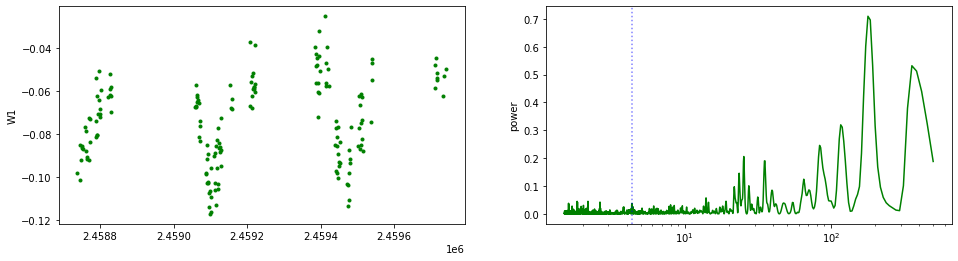

In [5]:
pca = PCA(n_components=Data.shape[1])
pca.fit(Data)

fig, ax = plt.subplots(1, 2, sharex='col', figsize=(16,4))

ax[0].plot(time_grid, pca.components_[0], 'g.')
ax[0].set_ylabel('W1')

frequency, power = LombScargle(time_grid, pca.components_[0]).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[1].plot(1/frequency, power, 'g')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ax[1].axvline(Prot, linestyle=':', color='b', alpha=0.5)

plt.show()

# SPCAndie

In [6]:
def periodo(ind, X, t, freq_grid, show = False):
    t, dlw  = popnan(ind, X, t)
    ls = LombScargle(t, dlw)#.autopower(minimum_frequency=0.0005, maximum_frequency=1/1.5)
    power = ls.power(freq_grid)
    max_freq = freq_grid[np.argmax(power)]
    return(power, 1/max_freq)

def popnan(ind, X, t):
    Xout = X[ind, np.invert(np.isnan(X[ind]))]
    tout = t[np.invert(np.isnan(X[ind]))]
    return(tout, Xout)

def PacMapDisp(X, n_neighbors=10, MN_rate=0.5, FP_rate=2.0):
    random.seed(110)
    X = X.reshape(X.shape[0], -1)
    # Initialize the pacmap instance
    # Setting n_neighbors to "None" leads to an automatic parameter selection
    # choice shown in "parameter" section of the README file.
    # Notice that from v0.6.0 on, we rename the n_dims parameter to n_components.
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbors, MN_ratio=MN_rate, FP_ratio=FP_rate, random_state = 110, apply_pca = True)
    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(X, init="pca")
    # visualize the embedding
    fig = plt.figure()
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="nipy_spectral", c=mf, s=2, norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.title('PacMap')
    plt.show()
    return(X_transformed)

100%|██████████| 15000/15000 [01:19<00:00, 188.34it/s]
/home/paul/.local/lib/python3.8/site-packages/pacmap/pacmap.py:774: UserWarning: Warning: random state is set to 110
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


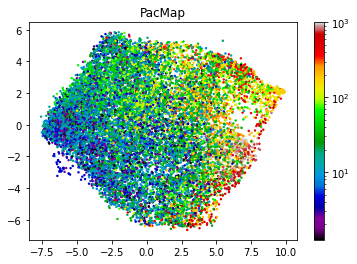

In [7]:
powers = []
mf = []
for i in tqdm(range(Data.shape[0])):
    p, m = periodo(i, Data, time_grid, new_freq) 
    powers.append(p)
    mf.append(m)
powers = np.array(powers)
mf = np.array(mf)

PacMap_map = PacMapDisp(powers)

(452, 2)
(618, 2)


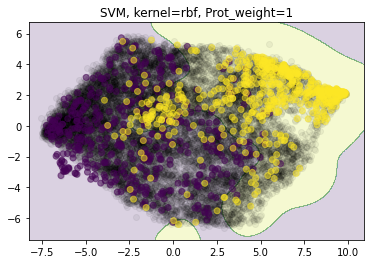

In [8]:
def select_per(Per, mxfq):
    U = Per * 0.05
    indlw = []
    for i in range(len(mxfq)):
        if mxfq[i]>Per-U and mxfq[i]<Per+U:
            indlw.append(i)
    return(indlw)

Pac_an_1  = PacMap_map[select_per(an, mf)]
Pac_an_2  = PacMap_map[select_per(an/2, mf)]
Pac_an_3  = PacMap_map[select_per(an/3, mf)]
Pac_prot_1  = PacMap_map[select_per(Prot, mf)]
Pac_prot_2  = PacMap_map[select_per(Prot/2, mf)]

Pac_prot = np.concatenate((Pac_prot_1, Pac_prot_2))
Pac_an   = np.concatenate((Pac_an_1, Pac_an_2, Pac_an_3))
print(Pac_prot.shape)
print(Pac_an.shape)
color_identification = np.concatenate((np.zeros_like(Pac_prot.T[0]), np.ones_like(Pac_an.T[0])))
Pac_split = np.concatenate((Pac_prot, Pac_an))

SVM_model = svm.SVC(kernel='rbf', gamma='auto', class_weight={0:1, 1:1})
SVM_model = SVM_model.fit(Pac_split, color_identification)

disp = DecisionBoundaryDisplay.from_estimator(SVM_model, Pac_split, response_method = 'predict', alpha = 0.2, grid_resolution=1000)
plt.scatter(PacMap_map[:,0], PacMap_map[:,1], c='k', alpha = 0.05)
plt.scatter(Pac_split[:,0], Pac_split[:, 1], c=color_identification, alpha=0.5)
plt.title('SVM, kernel=rbf, Prot_weight=1')
plt.show()

## Attribute a class for every lines

predicted_class = SVM_model.predict(PacMap_map)

In [9]:
data_filtr  = Data[predicted_class == 0]

In [10]:
pca_filtr = PCA(n_components=data_filtr.shape[1])
pca_filtr.fit(data_filtr)

PCA(n_components=168)

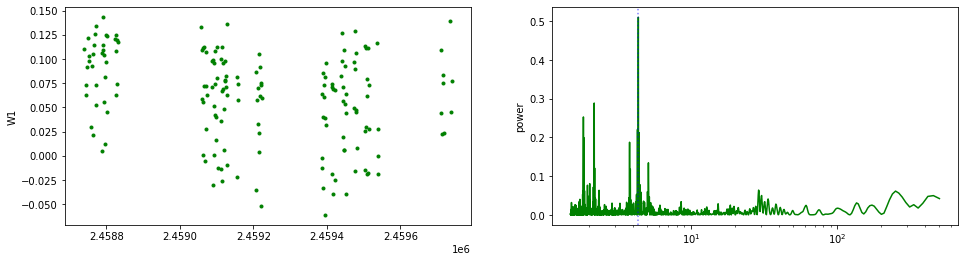

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(time_grid, pca_filtr.components_[0], 'g.')
ax[0].set_ylabel('W1')

frequency, power = LombScargle(time_grid, pca_filtr.components_[0]).autopower(minimum_frequency=1/500, maximum_frequency=1/1.5)
ax[1].plot(1/frequency, power, 'g')
ax[1].set_ylabel("power")
ax[1].set_xscale('log')
ax[1].axvline(Prot, linestyle=':', color='b', alpha=0.5)

plt.show()